# Лабораторная работа 6. Рекуррентные сети

В работе демонстрируется построение рекуррентной нейронной сети для посимвольной генерации текста.  

Полезные ссылки:
- [Andrej Karpathy – The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness)
- [Practical PyTorch: Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)
- [С. Николенко и др., 2018] – параграф 6.6.

In [ ]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

Задаем параметры:

In [2]:
filename = 'onegin.txt'  # Входной файл с текстом

seq_len = 200            # Размер последовательности для одной эпохи
batch_size_train = 1     # Размер батча для обучения
batch_size_test = 1      # Размер батча для предсказания (в данном случае всегда 1)
hidden_size = 100        # Размер скрытого состояния
embedding_size = 100     # Размер векторов-эмбеддингов для представления символов
num_layers = 1           # Количество слоев
lr = 0.005               # Скорость обучения
n_epochs = 1000          # Количество эпох
print_every = 100        # Интервал эпох для вывода результатов
plot_every = 10          # Интервал эпох для вывода потерь
predict_len = 100        # Количество символов для генерации

*Замечание*. Понятие "эпоха" обозначает период обработки всего обучающего множества. Но в контексте рекуррентных сетей это понятие может иметь значение, отличающееся от обычного, поскольку часто датасет бывает жестко не определен (например, из одного текста мы можем генерировать бесконечное количество последовательностей).  
Поэтому в данной лабораторной работе понятие "эпоха" обозначает период обработки всей последовательности размером `seq_len`.

Обеспечиваем воспроизводимость результатов (https://pytorch.org/docs/stable/notes/randomness.html):

In [3]:
torch.manual_seed(0)

---
Подготовьте входной текстовый файл. Можно взять ваше любимое художественное произведение.  
Здесь в качестве примера используется "Евгений Онегин".

In [4]:
with open(filename, encoding='utf-8') as f:
    data = f.read()
print(f'Длина текста: {len(data)} символов')
print(f'\nПервые {seq_len} строк:\n\n{data[:seq_len]}')

Длина текста: 144313 символов

Первые 200 строк:

ЕВГЕНИЙ ОНЕГИН

РОМАН В СТИХАХ

Petri  de  vanite  il  avait  encore plus de cette espece d'orgueil qui fait
avouer  avec  la  meme  indifference les bonnes comme les mauvaises actions,
suite d'un sen


---
Переводим текст в нижний регистр и создаем словарь всех символов:

In [5]:
data = data.lower()

vocabulary = set(data)
vocabulary = sorted(vocabulary)
print(f'Размер словаря: {len(vocabulary)}')
print(vocabulary)

Размер словаря: 82
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


---
Подготовим функцию для генерации случайных последовательностей длиной `seq_len+1` из входного текста.  
Единица прибавляется, так как в дальнейшем мы будем из этой сгенерированной последовательности получать две:
- *обучающую*, без последнего символа,
- *предсказываемую*, без первого символа.  

Таким образом, предсказываемая последовательность будет как бы сдвинута относительно обучающей на единицу вправо и каждый символ предсказываемой последовательности будет являться следующим символом для соответствующего обучающего символа.  
Обе последовательности будут на единицу меньше исходной последовательности.

In [6]:
def random_sequence(data, seq_len):
    start_index = random.randint(0, len(data) - seq_len - 1)
    end_index = start_index + seq_len + 1
    return data[start_index:end_index]

sequence = random_sequence(data, seq_len)
print(f'length = {len(sequence)}\n\n{sequence}')

length = 201

ых угрызений,
рукою стиснув пистолет,
глядит на ленского евгений.
"ну, что ж? убит", - решил сосед.
убит!.. сим страшным восклицаньем
сражен, онегин с содроганьем
отходит и людей зовет.
зарецкий бережн


---
Задаем модель:

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, input, hidden):
        # На вход поступает двумерный тензор индексов символов размерности (seq_len, batch_size)
        embeddings = self.embedding(input)

        # После слоя Embedding добавляется ещё одна размерность (векторов-эмбеддингов для индексов символов).
        # Итоговая размерность входа для RNN будет (seq_len, batch_size, embedding_size)
        output, hidden = self.rnn(embeddings, hidden)

        # Преобразуем скрытое состояние RNN для каждого символа в вероятности следующего символа.
        output = self.decoder(output)

        # Размерность выхода: (seq_len, batch_size, output_size=len(vocabulary))
        return output, hidden

    def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

Класс `Embedding` используется для формирования векторного представления каких-либо элементов (символов, слов, изображений, звуков и т.п.). Он представляет собой таблицу поиска (lookup table), на вход которой поступают индексы элементов, а на выходе выдаются векторные представления этих элементов ([справка PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)).  
Слой `Embedding` имеет свою матрицу весов, которые настраиваются в процессе обучения. Веса инициализируются из нормального распределения $N(0,1)$.  
После обучения слой `Embedding` будет содержать веса, в каком-то смысле "хорошо" представляющие входные элементы для текущей задачи.  
Данный слой при создании требует двух основных параметров:
- `num_embeddings` – размер словаря элементов (общее количество элементов, которые мы хотим закодировать);
- `embedding_dim` – размерность выходных векторов.  

Слой `Embedding` является, по сути, аналогом обычного слоя `Linear`, но `Linear` на входе ожидает вектор (например, *one-hot encoding* представление элементов), а на входе `Embedding` – тензоры любой размерности, содержащие просто индексы элементов, для которых необходимо получить векторное представление:

In [8]:
# Пример
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)
print(f'embedding.weight:\n{embedding.weight.data}')

i = torch.tensor(5)
print(f'\nВектор для элемента с индексом {i}:\n{embedding(i).data}')

array = torch.tensor([[1, 2], [4, 5]])
print(f'\nВекторы для массива индексов:\n{embedding(array).data}')

embedding.weight:
tensor([[-1.1258, -1.1524, -0.2506],
        [-0.4339,  0.8487,  0.6920],
        [-0.3160, -2.1152,  0.3223],
        [-1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377, -0.1435],
        [-0.1116, -0.6136,  0.0316],
        [-0.4927,  0.2484,  0.4397],
        [ 0.1124, -0.8411, -2.3160],
        [-0.1023,  0.7924, -0.2897],
        [ 0.0525,  0.5229,  2.3022]])

Вектор для элемента с индексом 5:
tensor([-0.1116, -0.6136,  0.0316])

Векторы для массива индексов:
tensor([[[-0.4339,  0.8487,  0.6920],
         [-0.3160, -2.1152,  0.3223]],

        [[ 0.1198,  1.2377, -0.1435],
         [-0.1116, -0.6136,  0.0316]]])


---
В итоге, модель будет выглядеть следующим образом:  

![image.png](attachment:ab07bd44-12b6-44d5-9465-d8e3e64d1899.png)

---
Функция, которая по входной строке возвращает список индексов из словаря `vocabulary`:

In [9]:
def char_to_tensor(string, vocabulary):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = vocabulary.index(string[c])
    return tensor

indices = char_to_tensor('онегин', vocabulary)
print(indices)

tensor([64, 63, 55, 53, 58, 63])


Напишем также функцию для обратного преобразования из списка индексов в строку:

In [10]:
def tensor_to_char(tensor, vocabulary):
    s = ''
    for t in tensor:
        s += vocabulary[int(t)]
    return s

print(tensor_to_char(indices, vocabulary))

онегин


---
Напишем функцию для генерации пары (входная последовательность, выходная последовательность).  
В качестве входной (обучающей) последовательности выступает случайная строка без последнего символа;  
выходная последовательность – та же строка без первого символа.  
Таким образом, каждому элементу входной последовательности (символу) соответствует элемент выходной последовательности (символ), который является следующим символом в строке.  
Выходная последовательность является целевой переменной, именно её сеть будет пытаться предсказать.  
Размер каждой последовательности – `seq_len`.

In [11]:
def random_training_set(data, seq_len, vocabulary):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    return input, target

In [12]:
input, target = random_training_set(data, seq_len, vocabulary)

print(f'********** input ({len(input)})**********\n\n{input.data}')
print(f'\n********** target ({len(target)}) **********\n{target.data}')

********** input (200)**********

tensor([51, 55, 67, 58, 68, 78,  1, 64, 65, 61, 64, 74, 63, 64, 53, 64,  1, 52,
        66, 50, 53, 50, 21,  0, 65, 66, 58, 81, 68, 63, 64,  1, 57, 66, 55, 68,
        78,  7,  1, 60, 50, 60,  1, 64, 63,  7,  1, 69, 65, 66, 81, 62, 64,  0,
        67, 60, 61, 64, 63, 58, 52,  1, 51, 64, 54, 61, 58, 52, 77, 55,  1, 66,
        64, 53, 50,  7,  0, 63, 55, 52, 64, 61, 78, 63, 64,  1, 52,  1, 57, 55,
        66, 60, 50, 61, 64,  1, 53, 61, 81, 54, 58, 68, 67, 81,  0, 58,  1, 69,
        57, 63, 50, 52, 50, 68, 78,  1, 67, 55, 51, 81,  1, 67, 68, 77, 54, 58,
        68, 67, 81, 21,  0, 65, 66, 58, 81, 68, 63, 55, 59,  7,  1, 55, 67, 61,
        58,  1, 64, 63,  7,  1, 54, 66, 69, 57, 78, 81,  7,  0, 57, 50, 52, 64,
        55, 68,  1, 67, 54, 69, 66, 69, 20,  1, 79, 68, 64,  1, 81,  2,  0, 55,
        75, 55,  1, 65, 66, 58, 81, 68, 63, 55, 55,  1, 52,  1, 62, 64, 61, 73,
        50, 63])

********** target (200) **********
tensor([55, 67, 58, 68, 78,  1, 6

Преобразуем полученные тензоры в строки:

In [13]:
print(f'********** input **********\n\n{tensor_to_char(input, vocabulary)}')
print(f'\n********** target **********\n\n{tensor_to_char(target, vocabulary)}')

********** input **********

бесить оплошного врага;
приятно зреть, как он, упрямо
склонив бодливые рога,
невольно в зеркало глядится
и узнавать себя стыдится;
приятней, если он, друзья,
завоет сдуру: это я!
еще приятнее в молчан

********** target **********

есить оплошного врага;
приятно зреть, как он, упрямо
склонив бодливые рога,
невольно в зеркало глядится
и узнавать себя стыдится;
приятней, если он, друзья,
завоет сдуру: это я!
еще приятнее в молчань


---
RNN требует на вход трехмерный тензор размерностью: `(seq_len, batch_size, input_size)`:
\
\
![image.png](attachment:d01f78ba-de9b-4395-909b-5dde3b9448e1.png)


Таким образом, последовательности символов будут располагаться вдоль размерности `seq_len`.

Этот трехмерный тензор подается на вход RNN по мини-батчам:
\
\
![image.png](attachment:cfc06c53-9465-49a0-9d5f-7e4e5a6425dd.png)

Каждый мини-батч обрабатывается в RNN одновременно; при этом формируется столько же скрытых состояний, сколько векторов в мини-батче. Эти скрытые состояния также являются выходами RNN: на каждый вектор мини-батча – свой выходной вектор (он же скрытое состояние).

В нашем примере:
- `input_size = 1` – на вход подается только индекс текущего символа в словаре, который в слое `Embedding` преобразуется в вектор размерности `embedding_size`;
- `batch_size = batch_size_train` – размер мини-батча;
- `seq_len = 200` – длина последовательности символов на одном шаге:
\
\
![image.png](attachment:8679163a-d1a4-45ef-aeb3-d0ba39cc1475.png)

---
Зададим функцию обучения для одной эпохи – это процедура обработки в RNN всех мини-батчей, входящих в последовательность размером `seq_len`. Каждый мини-батч включает всего один индекс символа в словаре.  

Инициализация (обнуление) скрытого состояния происходит в начале каждого шага. Существует две стратегии инициализации скрытого состояния:
1. Если обрабатываются продолжительные непрерывные входные данные (например, "Война и мир"), разбитые на последовательности, и последовательность на текущем шаге является продолжением последовательности на предыдущем шаге, то скрытые состояния можно передавать с предыдущей эпохи (после обработки всей последовательности).
1. Если датасет состоит из отдельных последовательностей, не связанных между собой (например, твитов), то скрытое состояние желательно обнулять перед каждой эпохой.  

В нашем примере последовательности для каждой эпохи формируются независимо друг от друга, поэтому скрытые состояния обнуляются.

In [14]:
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size)

    rnn.zero_grad()
    loss = 0

    outputs, hidden = rnn(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

---
Операция `view` в PyTorch создает новый тензор как "представление" существущего тензора: сами данные никуда не копируются, но размерность данных меняется. Таким образом, экономятся память и время.

In [15]:
# Пример
t = torch.rand(2, 2)
print(f'Исходный тензор:\n{t}')

b = t.view(1, -1)
print(f'\nТензор-представление (view):\n{b}')

# Данные в обоих тензорах разделяются
print(f'\nДанные совпадают? - {t.untyped_storage().data_ptr() == b.untyped_storage().data_ptr()}')

# Изменение тензора-представления изменяет базовый тензор
b[0][1] = 1
print(f'\nИсходный тензор:\n{t}')

# Растягиваем двумерный тензор в одномерный
b = b.view(-1)
print(f'\nОдномерный тензор:\n{b}')

Исходный тензор:
tensor([[0.8155, 0.7932],
        [0.2783, 0.4820]])

Тензор-представление (view):
tensor([[0.8155, 0.7932, 0.2783, 0.4820]])

Данные совпадают? - True

Исходный тензор:
tensor([[0.8155, 1.0000],
        [0.2783, 0.4820]])

Одномерный тензор:
tensor([0.8155, 1.0000, 0.2783, 0.4820])


---
Напишем функцию, генерирующую текст длины `predict_len` с началом (префиксной строкой) `prefix`.  
Результирующая строка будет иметь вид: `prefix` + сгенерированная строка.

In [16]:
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1)
        outputs, hidden = model(input, hidden)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1)

    return predicted

Вспомогательная функция для вывода времени:

In [17]:
def time_since(since):
    seconds = time.time() - since
    minutes = math.floor(seconds / 60)
    seconds -= minutes * 60
    return f'{minutes} min {seconds:.0f} sec'

---
Основная процедура обучения и генерации примеров текста в процессе обучения.  
Генерация текстов в ходе обучения необходима только для иллюстрации изменений возможностей модели по мере обучения.

In [18]:
# Создаем модель
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):

    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary)
    input = input.view(-1, 1)
    target = target.view(-1, 1)

    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)

    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:

        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')

        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0135]
ам,
пакитоветь е в та . 
е тегодавы,
о слежнек по дожал ..
в седвени;
но то село на . vii

xxx . . . 

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0127]
авно б хосна веси, ослы одго дрем.
вют, облег на вальныет
и сновальем бемнов!
кна босемя влецак сетви

[time = 0 min 5 sec, epochs = 300 (30.0%), loss = 0.0120]
адевдей! - бестиланьясчистластенивке парегияшочут!ный расляний пирнит
в и былкита?.
не завша рамлийме

[time = 0 min 6 sec, epochs = 400 (40.0%), loss = 0.0122]
а?
хноча:
в о рабымный на и собренит блун кного,
как же щеда к казслудсей, к нег
и лесчитей
свеслик;


[time = 0 min 8 sec, epochs = 500 (50.0%), loss = 0.0108]
авою с одложде нед своеги
его дето,
ток то пероделтие,
в квы омогостых ордашу, оня титсе прювной полу

[time = 0 min 9 sec, epochs = 600 (60.0%), loss = 0.0113]
акажет
но она залавы,
остет рамяпливынной,
и сослова?
ножал
ний трость деесном позрасталь послого уми

[time = 0 min 11 sec, epochs = 700

---
Рисуем график потерь:

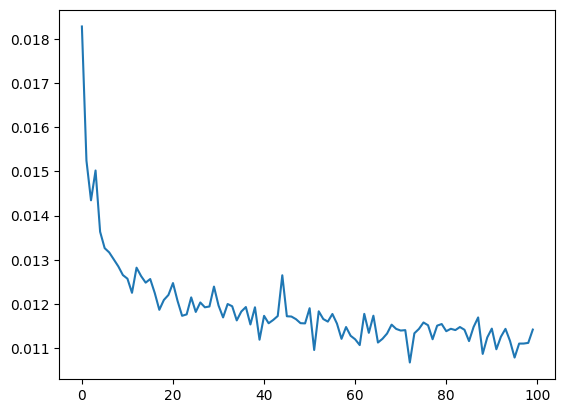

In [19]:
plt.figure()
plt.plot(all_losses)

После обучения можно подставить любое начало и сеть его продолжит:

In [20]:
beginning = 'мой дядя'

predict = evaluate(
    model=rnn,
    vocabulary=vocabulary,
    batch_size=batch_size_test,
    prefix=beginning,
    predict_len=predict_len
)

print(predict)

мой дядя трежменья
сузам де груш нейны,
в дыл свитею: кра, и мой моли и кевилит!

xlix

и соркин том
солги м


---
#### Задание 1.
Перенесите модель и данные на GPU.

In [21]:
if torch.cuda.is_available():
    print("✅ GPU доступен!")
    print("Название GPU:", torch.cuda.get_device_name(0))
    print("Версия CUDA (драйвер):", torch.version.cuda)  # Версия CUDA, которую видит PyTorch
    print("Версия PyTorch:", torch.__version__)
else:
    print("❌ GPU не обнаружен. Colab работает на CPU.")

❌ GPU не обнаружен. Colab работает на CPU.


In [22]:
# Проверяем доступность CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [23]:
# Модификация функции random_train_set
def random_training_set(data, seq_len, vocabulary, device):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    input = torch.tensor(input, dtype=torch.long, device=device)  # Перенос на GPU
    target = torch.tensor(target, dtype=torch.long, device=device)
    return input, target

In [24]:
# Создаем модель и переносим на GPU
rnn = RNN(
    input_size=len(vocabulary),
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    output_size=len(vocabulary),
    num_layers=num_layers
).to(device)

rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [25]:
# Модификация функции train
def train(input, target, batch_size):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем скрытое состояние
    hidden = rnn.init_hidden(batch_size=batch_size).to(device)

    rnn.zero_grad()
    loss = 0

    outputs, hidden = rnn(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

In [26]:
# Модификация init_hidden
def init_hidden(self, batch_size):
        # Должна быть размерность (num_layers * num_directions, batch_size, hidden_size)
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [27]:
# Модификация функции evaluate
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden = model.init_hidden(batch_size).to(device)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden = model(input, hidden)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden = model(input, hidden)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [28]:
# Проверка
print("Model device:", next(rnn.parameters()).device)
sample_input = torch.tensor([0], device=device)
print("Sample input device:", sample_input.device)

Model device: cpu
Sample input device: cpu


In [29]:
# Основной цикл обучения
start = time.time()

prefix = 'а'         # Префиксная строка для генерации в процессе обучения.

all_losses = []      # Список значений функции потерь в процессе обучения (для графика)
loss_avg = 0         # Усредненное по `plot_every` эпохам значение функции потерь для графика

for epoch in range(1, n_epochs + 1):

    # Генерируем первую последовательность
    input, target = random_training_set(data, seq_len, vocabulary, device)
    input = input.view(-1, 1)
    target = target.view(-1, 1)

    # Добавляем к первой последовательности другие в зависимости от количества мини-батчей
    for b in range(batch_size_train-1):
        sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)
        sequence = sequence.view(-1, 1)
        target_seq = target_seq.view(-1, 1)
        input = torch.cat((input, sequence), dim=1)
        target = torch.cat((target, target_seq), dim=1)

    # Запускаем эпоху обучения
    loss = train(input, target, batch_size_train)
    loss_avg += loss

    # Осуществляем генерацию текста для текущей модели каждые `print_every` эпох
    if epoch % print_every == 0:

        print(f'[time = {time_since(start)}, epochs = {epoch} ({epoch / n_epochs * 100}%), loss = {loss:.4f}]')

        predicted_text = evaluate(
            model=rnn,
            vocabulary=vocabulary,
            batch_size=batch_size_test,
            prefix=prefix,
            predict_len=predict_len
        )
        print(predicted_text)
        print()

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/tmp/ipykernel_142345/1972840392.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.long, device=device)  # Перенос на GPU
/tmp/ipykernel_142345/1972840392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long, device=device)


[time = 0 min 2 sec, epochs = 100 (10.0%), loss = 0.0124]
а, докий, тобь л тамя илоть седдо,
н естов тогалине дет,
хре подбле- в ледешет вал вать.
о-тто днер т

[time = 0 min 3 sec, epochs = 200 (20.0%), loss = 0.0120]
ам цазнобя подно менен
дне пр9ебнея ду, оо нет ить пебемасчума лно
ь сорда. . дун, рон пре"рот
и жне?

[time = 0 min 5 sec, epochs = 300 (30.0%), loss = 0.0116]
азом сейшях:
и отаринь суздыста, нак яльаньена, вых гнабить; и востуюно казосьдок, лет,
боркой душко,

[time = 0 min 6 sec, epochs = 400 (40.0%), loss = 0.0123]
абвилась отладны доль -
вншу,
с ра нены столит забкиниз,
ти зораньет,
декрысь поливнум осараком и мол

[time = 0 min 8 sec, epochs = 500 (50.0%), loss = 0.0120]
асплнен, порите ответелелукае:
не моготной нерго чикрасные поиши токотка
леленежили одветсхолутитпрые

[time = 0 min 9 sec, epochs = 600 (60.0%), loss = 0.0116]
ать одима ленье. сви наде в глено вскаv
ним сорики,
я надит людкий. . . . . . . . .
грудеи ланче идме

[time = 0 min 11 sec, epochs = 700

#### Задание 2.
Запустите обучение модели с разным количеством эпох и размером мини-батча. Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [30]:
from datetime import datetime

# Конфигурация экспериментов
experiments = [
    {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1},
    {'n_epochs': 100, 'batch_size_train': 32, 'batch_size_test': 1},
    {'n_epochs': 200, 'batch_size_train': 32, 'batch_size_test': 1},
    {'n_epochs': 50, 'batch_size_train': 64, 'batch_size_test': 1},
    {'n_epochs': 100, 'batch_size_train': 64, 'batch_size_test': 1},
    {'n_epochs': 200, 'batch_size_train': 64, 'batch_size_test': 1},
    {'n_epochs': 50, 'batch_size_train': 128, 'batch_size_test': 1},
    {'n_epochs': 100, 'batch_size_train': 128, 'batch_size_test': 1},
    {'n_epochs': 200, 'batch_size_train': 128, 'batch_size_test': 1},
    {'n_epochs': 300, 'batch_size_train': 64, 'batch_size_test': 1}
]


In [31]:

results = []

for exp_idx, config in enumerate(experiments, 1):
    print(f"\n=== Эксперимент {exp_idx}/{len(experiments)} ===")
    print(f"Параметры: {config}")

    # Инициализация модели для каждого эксперимента
    rnn = RNN(
        input_size=len(vocabulary),
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        output_size=len(vocabulary),
        num_layers=num_layers
    ).to(device)

    rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

    # Основной цикл обучения
    start_time = time.time()
    all_losses = []
    loss_avg = 0
    best_text = ""
    best_loss = float('inf')

    for epoch in range(1, config['n_epochs'] + 1):
        # Обучение (ваш существующий код)
        input, target = random_training_set(data, seq_len, vocabulary, device)
        input = input.view(-1, 1)
        target = target.view(-1, 1)

        for b in range(config['batch_size_train']-1):
            sequence, target_seq = random_training_set(data, seq_len, vocabulary, device)
            sequence = sequence.view(-1, 1)
            target_seq = target_seq.view(-1, 1)
            input = torch.cat((input, sequence), dim=1)
            target = torch.cat((target, target_seq), dim=1)

        loss = train(input, target, config['batch_size_train'])
        loss_avg += loss

        # Сохраняем лучший результат
        if loss < best_loss:
            best_loss = loss
            best_text = evaluate(
                model=rnn,
                vocabulary=vocabulary,
                batch_size=config['batch_size_test'],
                prefix=prefix,
                predict_len=predict_len,
            )

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    # Сохранение результатов эксперимента
    experiment_time = time.time() - start_time
    results.append({
        'experiment_id': exp_idx,
        'parameters': config,
        'training_time': experiment_time,
        'final_loss': loss,
        'best_generated_text': best_text,
        'all_losses': all_losses
    })

    print(f"Эксперимент {exp_idx} завершен за {experiment_time:.2f} сек")
    print(f"Лучший сгенерированный текст:\n{best_text}\n")




=== Эксперимент 1/10 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1}


/tmp/ipykernel_142345/1972840392.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.long, device=device)  # Перенос на GPU
/tmp/ipykernel_142345/1972840392.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long, device=device)


Эксперимент 1 завершен за 7.07 сек
Лучший сгенерированный текст:
а нох гуда пструтухнак налей лорвтаб, по-т я!
баторит мошумму ледьу нешкак,
и ласной и в выт гду, про


=== Эксперимент 2/10 ===
Параметры: {'n_epochs': 100, 'batch_size_train': 32, 'batch_size_test': 1}
Эксперимент 2 завершен за 11.61 сек
Лучший сгенерированный текст:
ажна!" (здал быле,
дришее,
бпадапелевилод.
чта ейстраши проты
капраней прако лро родценный", уграв бы


=== Эксперимент 3/10 ===
Параметры: {'n_epochs': 200, 'batch_size_train': 32, 'batch_size_test': 1}
Эксперимент 3 завершен за 24.46 сек
Лучший сгенерированный текст:
а золодит но перердцах он готовеи клюданшку не в вегечещ {1узслады лизный нансмять, бедеться сенты за


=== Эксперимент 4/10 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 64, 'batch_size_test': 1}
Эксперимент 4 завершен за 8.22 сек
Лучший сгенерированный текст:
ажной. рово,
беля" наю в вемым бый. сзами, прегумабона мило ме музв, жвостет ги . на
. . . . и чти мо


=== Эксперимент 5/10 ==

In [32]:
import csv
def save_to_file(results, name_model):
  # Подготовка данных для CSV
  csv_data = []
  for exp in results:
      # Преобразуем все loss значения
      all_losses = [loss.item() if torch.is_tensor(loss) else loss for loss in exp['all_losses']]
      final_loss = exp['final_loss'].item() if torch.is_tensor(exp['final_loss']) else exp['final_loss']

      csv_data.append({
          'experiment_id': exp['experiment_id'],
          'n_epochs': exp['parameters']['n_epochs'],
          'batch_size_train': exp['parameters']['batch_size_train'],
          'batch_size_test': exp['parameters']['batch_size_test'],
          'training_time_sec': round(exp['training_time'], 2),
          'final_loss': round(float(final_loss), 5),
          'best_generated_text': exp['best_generated_text'],
          'min_loss': round(float(min(all_losses)), 5),
          'max_loss': round(float(max(all_losses)), 5),
          'last_5_losses': ', '.join([str(round(float(x), 5)) for x in all_losses[-5:]])
      })

  # Определяем заголовки CSV
  fieldnames = [
      'experiment_id',
      'n_epochs',
      'batch_size_train',
      'batch_size_test',
      'training_time_sec',
      'final_loss',
      'min_loss',
      'max_loss',
      'last_5_losses',
      'best_generated_text'
  ]

  # Сохраняем в CSV файл
  timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
  filename = f"{name_model}_experiments_{timestamp}.csv"

  with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()
      writer.writerows(csv_data)

  print(f"Результаты успешно сохранены в {filename}")

In [33]:
save_to_file(results, 'rnn')

Результаты успешно сохранены в rnn_experiments_13062025_154124.csv


In [34]:
def plot_loss(results, name_model):
  plt.figure(figsize=(12, 6))

  for res in results:
      # Преобразуем losses из тензоров в numpy массив на CPU
      if isinstance(res['all_losses'][0], torch.Tensor):
          losses = [loss.cpu().item() for loss in res['all_losses']]
      else:
          losses = res['all_losses']

      plt.plot(losses, label=f"Exp {res['experiment_id']} (epochs={res['parameters']['n_epochs']}, bs={res['parameters']['batch_size_train']})")

  plt.title(f"Training Loss Across Experiments for {name_model}")
  plt.xlabel('Iterations (every {} epochs)'.format(plot_every))
  plt.ylabel('Loss')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.show()

  plt.savefig(f"{name_model}_training_loss_comparison.png", dpi=300, bbox_inches='tight')

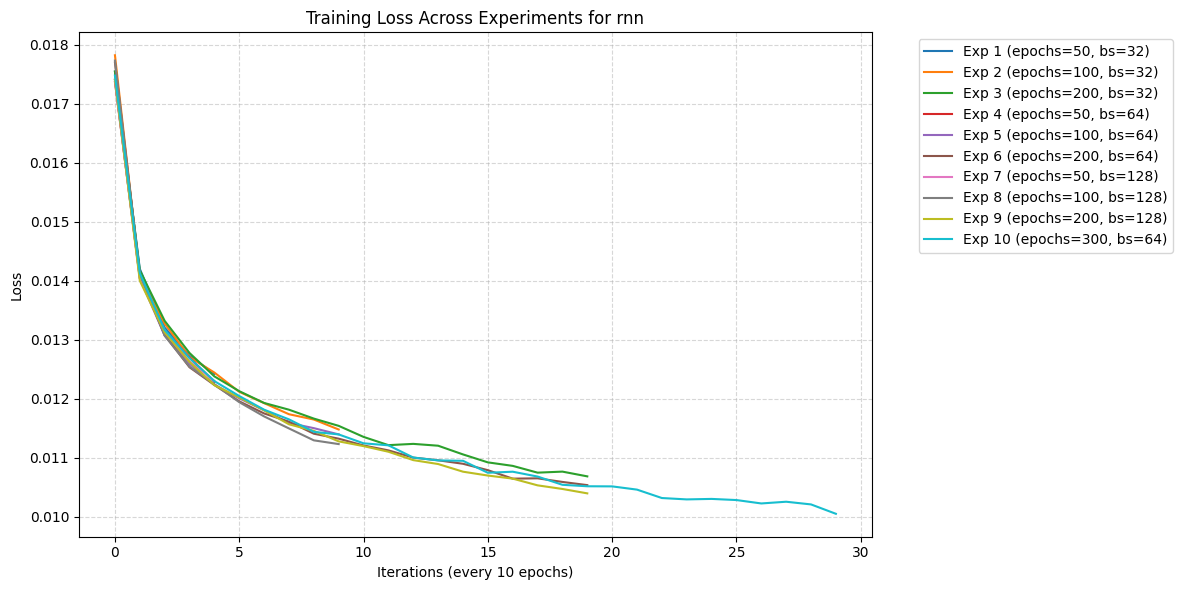

<Figure size 640x480 with 0 Axes>

In [35]:
plot_loss(results,'rnn')

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Задание 3.
Поменяйте модуль Simple RNN на LSTM. Запустите обучение модели с разным количеством эпох и размером мини-батча.  
Желательно, чтобы параметры совпадали с предыдущим экспериментом и можно было сравнивать модели.  
Один или несколько результатов генерации в конце каждого эксперимента вместе с временем запуска и параметрами запишите в отдельный файл.  
Проведите не менее 10 экспериментов.  
Сделайте выводы об эффективности разных вариантов модели.

In [37]:
# Проверяем доступность CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [38]:
# Описание класса LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Слой embedding
        self.embedding = nn.Embedding(input_size, embedding_size)

        # LSTM слой вместо RNN
        self.lstm = nn.LSTM(embedding_size,
                           hidden_size,
                           num_layers=num_layers,
                           batch_first=True)

        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, output_size)

        # Перенос всех параметров на устройство
        self.to(self.device)

    def forward(self, x, hidden):
        # hidden_cell - это кортеж (hidden_state, cell_state)
        x = x.to(self.device)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_size)

        # LSTM возвращает output, (hidden_state, cell_state)
        output, hidden = self.lstm(embedded, hidden)

        # Преобразуем output перед полносвязным слоем
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        # Инициализируем hidden и cell states
        hidden_cell = (
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device= self.device)
        )
        return hidden_cell


In [39]:
# Модификация функции random_train_set
def random_training_set(data, seq_len, vocabulary, device):
    sequence = random_sequence(data, seq_len)
    input = char_to_tensor(sequence[:-1], vocabulary)
    target = char_to_tensor(sequence[1:], vocabulary)
    input = torch.tensor(input, dtype=torch.long, device=device).unsqueeze(1),  # Добавляем размерность батча
    target = torch.tensor(target, dtype=torch.long, device=device).unsqueeze(1)#,  # Добавляем размерность батча
    return (input, target)

In [40]:
# Модификация функции train
def train(input, target, batch_size, model, optimizer, criterion):
    '''
    input - тензор размерности (seq_len, batch_size). Тензор содержит индексы символов.
    target - истинная последовательность индексов следующих символов (целевая переменная); размерность (seq_len, batch_size)
    '''

    # Инициализируем hidden и cell states
    hidden_cell = model.init_hidden(batch_size)

    # Убедимся, что данные на правильном устройстве
    input = input.to(model.device)
    target = target.to(model.device)

    model.zero_grad()
    loss = 0

    outputs, hidden = model(input, hidden)

    # Преобразуем размерности для вычисления функции потерь
    outputs = outputs.view(seq_len * batch_size, -1)
    target = target.view(seq_len * batch_size)

    loss = criterion(outputs, target)

    loss.backward()
    rnn_optimizer.step()

    return loss.data / len(input)

In [41]:
# Модификация функции evaluate
def evaluate(model, vocabulary, batch_size, prefix='а', predict_len=100):

    # Инициализируем скрытое состояние
    hidden_cell = model.init_hidden(batch_size)

    # Преобразуем префиксную строку в тензор индексов
    prefix_input = char_to_tensor(prefix, vocabulary)

    # В переменной predicted будет храниться порождаемая строка (результат работы всей функции).
    # Записываем в неё сначала префиксную строку
    predicted = prefix

    # Запускаем модель на префиксной строке - формируем скрытое состояние для дальнейшей генерации
    for p in range(len(prefix) - 1):
        input = prefix_input[p]
        input = input.view(-1, 1).to(device)
        outputs, hidden_cell = model(input, hidden_cell)

    # В качестве первого символа для генерации (предсказания следующего символа) выступает последний символ префиксной строки
    input = prefix_input[-1]
    input = input.reshape(-1, 1).to(device)

    # Генерируем predict_len символов
    for p in range(predict_len):

        # Запускаем модель с текущим входным символом и текущим скрытым состоянием
        output, hidden_cell = model(input, hidden_cell)

        # В output возвращаются вероятности всех символов из словаря.
        # Выбираем из этого распределения символ (сэмплируем)
        output_dist = output.data.view(-1)
        output_dist = output_dist.exp()
        top_index = torch.multinomial(output_dist, 1)[0]

        # Добавляем предсказанный символ в результирующую строку
        predicted_char = vocabulary[top_index]
        predicted += predicted_char

        # Используем предсказанный символ как следующий вход
        input = char_to_tensor(predicted_char, vocabulary)
        input = input.reshape(-1, 1).to(device)

    return predicted

In [42]:
def training_model(name_model):
  results = []

  for exp_idx, config in enumerate(experiments, 1):
    print(f"\n=== Эксперимент {exp_idx}/{len(experiments)} ===")
    print(f"Параметры: {config}")

    # Инициализация модели для каждого эксперимента
    if name_model=='rnn':
      model = RNN(
        input_size=len(vocabulary),
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        output_size=len(vocabulary),
        num_layers=num_layers
      ).to(device)
    elif name_model=='LSTM':
      model = LSTM(
        input_size=len(vocabulary),
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        output_size=len(vocabulary),
        num_layers=num_layers
      )
    '''
    else:
      model = GRU(
        input_size=len(vocabulary),
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        output_size=len(vocabulary),
        num_layers=num_layers
      )
    '''

    model_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Основной цикл обучения
    start_time = time.time()
    all_losses = []
    loss_avg = 0
    best_text = ""
    best_loss = float('inf')

    for epoch in range(1, config['n_epochs'] + 1):
        # Обучение (ваш существующий код)
        input, target = random_training_set(data, seq_len, vocabulary, device=model.device)
        #input = input.view(-1, 1).to(device)
        #target = target.view(-1, 1).to(device)

        for b in range(config['batch_size_train']-1):
            sequence, target_seq = random_training_set(data, seq_len, vocabulary, device=model.device)
            #sequence = sequence.view(-1, 1)
            #target_seq = target_seq.view(-1, 1)

            # Проверка и преобразование если необходимо
            if isinstance(sequence, tuple):
                sequence = sequence[0]  # Берем первый элемент если это кортеж
            if isinstance(target_seq, tuple):
                target_seq = target_seq[0]

            input = torch.cat((input, sequence), dim=1)
            target = torch.cat((target, target_seq), dim=1)

        loss = train(input, target, config['batch_size_train'], model, model_optimizer, criterion)
        loss_avg += loss

        # Сохраняем лучший результат
        if loss < best_loss:
            best_loss = loss
            best_text = evaluate(
                model=rnn,
                vocabulary=vocabulary,
                batch_size=config['batch_size_test'],
                prefix=prefix,
                predict_len=predict_len,
            )

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

    # Сохранение результатов эксперимента
    experiment_time = time.time() - start_time
    results.append({
        'experiment_id': exp_idx,
        'parameters': config,
        'training_time': experiment_time,
        'final_loss': loss,
        'best_generated_text': best_text,
        'all_losses': all_losses
    })

    print(f"Эксперимент {exp_idx} завершен за {experiment_time:.2f} сек")
    print(f"Лучший сгенерированный текст:\n{best_text}\n")
  return results

In [43]:
results = training_model('LSTM')

save_to_file(results, 'LSTM')

plot_loss(results,'LSTM')


=== Эксперимент 1/10 ===
Параметры: {'n_epochs': 50, 'batch_size_train': 32, 'batch_size_test': 1}


/tmp/ipykernel_142345/1587237110.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.long, device=device).unsqueeze(1),  # Добавляем размерность батча
/tmp/ipykernel_142345/1587237110.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long, device=device).unsqueeze(1)#,  # Добавляем размерность батча


TypeError: expected Tensor as element 0 in argument 0, but got tuple

#### Задание 4.
Повторите предыдущее задание для модуля GRU.  
Кроме выводов об эффективности, сделайте выводы о времени обучения разных моделей – Simple RNN, LSTM, GRU.

#### Задание 5.
Выберите лучшую модель по результатам предыдущих экспериментов и попробуйте добиться повышения качества за счёт разного количества слоёв.

#### Задание 6.
Прочитайте в [Николенко и др., 2018, стр. 266] о понятии "температура", которое часто используется при генерации текстов.  
Добавьте данный параметр в функцию `evaluate()`.  
Проверьте его влияние на результаты генерации.

#### Задание 7 (факультативное).
Разбейте текст на последовательности не случайным образом, а по предложениям.  
Предложения можно получить из текста при помощи функции `nltk.tokenize.sent_tokenize()`.  
Так как предложения окажутся неодинаковой длины, а последовательности на вход модели должны поступать одинакового размера, придется дополнить предложения до максимальной длины символом, не входящим в словарь (например, каким-нибудь из [управляющих символов](https://ru.wikipedia.org/wiki/Управляющие_символы) `\0`, `\a`, `\b` и т.д.).

#### Задание 8 (факультативное).
Реализуйте стратегию 3 из учебника [Николенко и др., 2018, стр. 260] – разбиение текста на последовательности примерно одной длины с правильно инициализированными скрытыми состояниями рекуррентной сети.